# Diseño de un sistema de aprendizaje automático 


La utilización de sistemas de aprendizaje automatico se esta haciendo mas comun con el paso del tiempo, de ahi que se han implementado diversas soluciones como el recocimiento de patrones. El objetivo de este proyecto es armar un sistema de reconocimiento de patrones para ser utilizado en un sistema empotrado, específicamente en el dispositivo Jetson Nano™ de Nvidia®.

La red neuronal seleccionada para este propósito es la Red Residual Profunda (*Deep Residual Network*).  Ésta se caracteriza por usar los valores originales en algunas capas de la red neuronal, cuando en las otras redes los valores originales únicamente ingresan a la primera capa de la red.  La figura 1 muestra un ejemplo del flujo de la información a través de tres capas de una red residual.

La principal ventaja de una red neuronal residual es la preservación de los gradientes indiferentemente de la profundidad de la red.

<div>
    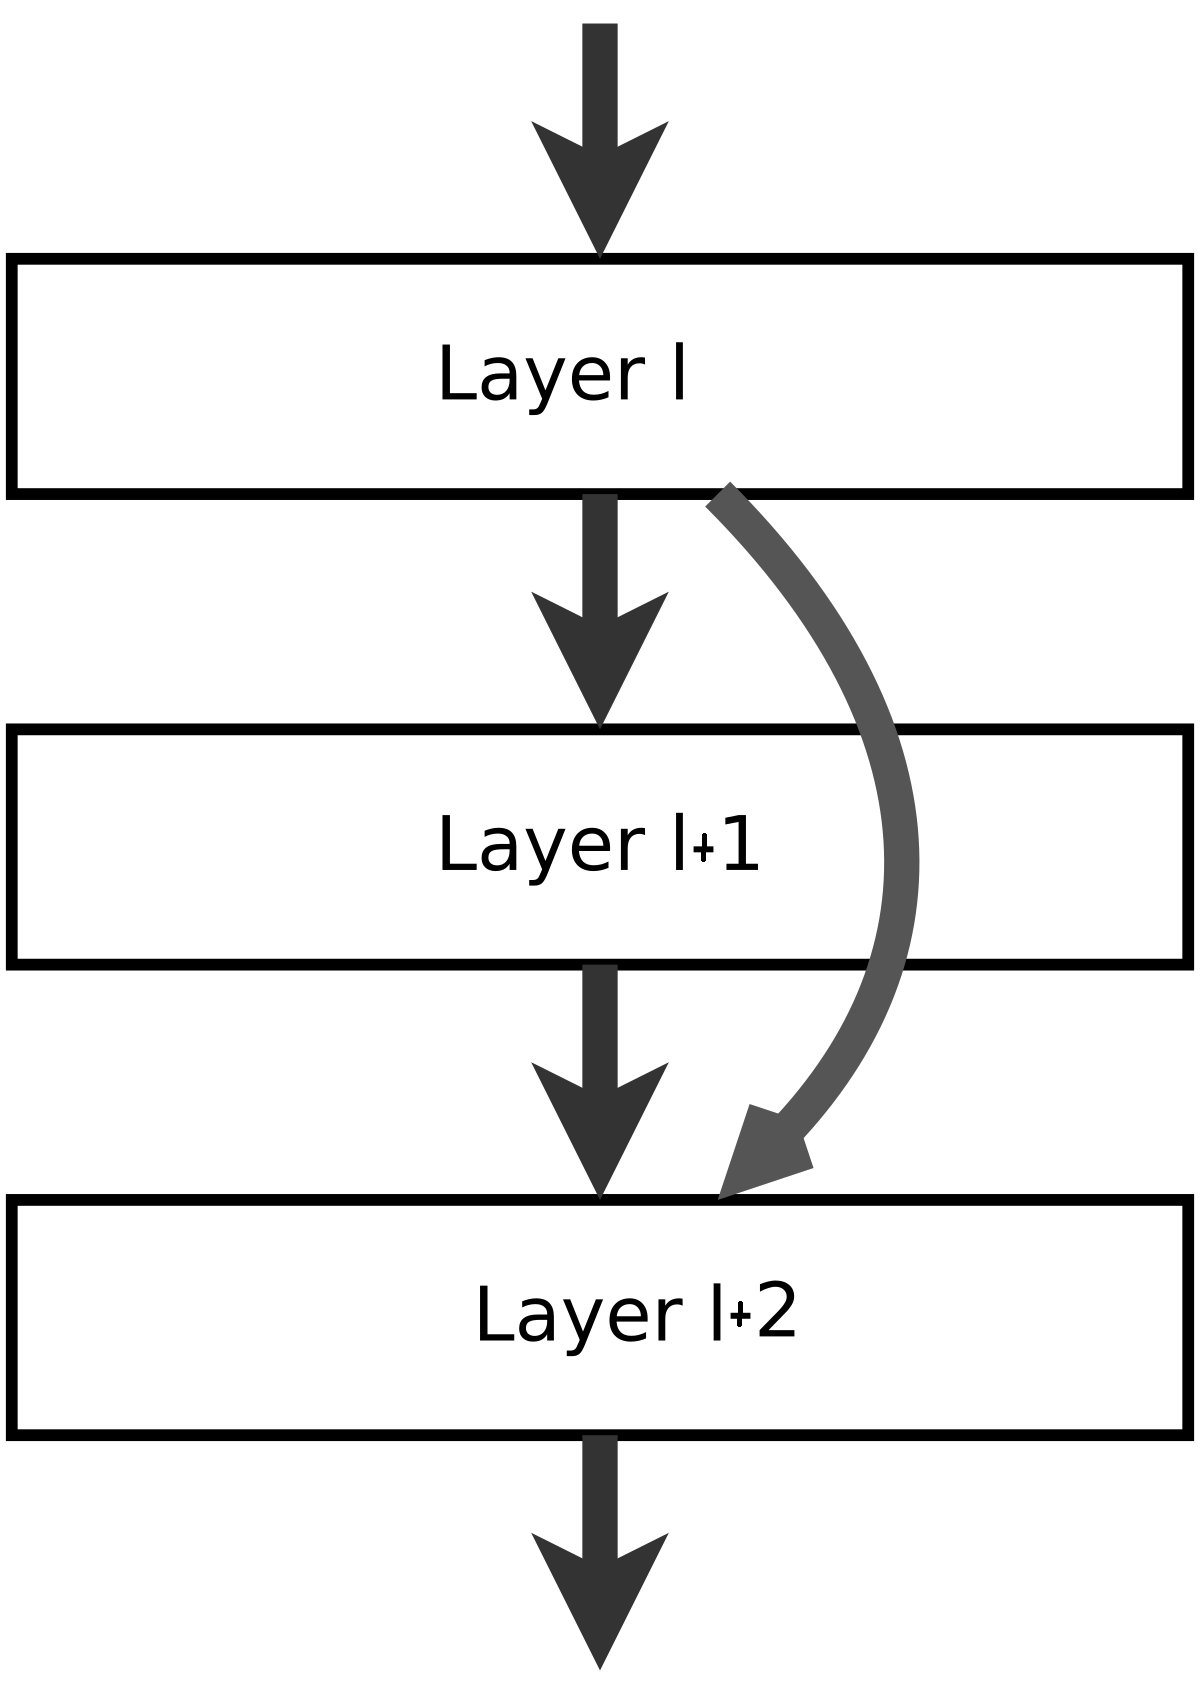
</div>
<Center>Figura 1. Ejemplo del flujo de una red residual de tres capas.</Center>

Debido a los requrimientos computacionales altos para el aprendizaje automático, se recomienda el uso de una computadora para el desarrollo del sistema de reconocimiento de patrones en una computadora ajena a la Jetson Nano™.  Adicionalmente, es recomendable utilizar una computadora con GPU incorporada para agilizar el proceso de entrenamiento del sistema de reconocimiento de patrones.

Para la implementación del sistema de aprendizaje automatico se utilizó la siguiente estructura:
* Selección de un conjunto de datos.
* Pre-procesado de datos.
* Diseño del esquema de CNN.
* Pruebas de entrenamiento.
* Pruebas de validación

## Selección de un conjunto de datos

Se selecciono un conjunto de datos de mediana complejidad el cual involucra la aplicación de imagenes, detección de objetos. Despues de realizar una busqueda en el sitio web https://www.kaggle.com/ donde se seleciono un conjuto de datos de vehiculos el cual contiene 16,185 imagenes con 196 clases de vehiculos. Los datos estan divididos en 8,144 imagenes de entrenamiento y 8,041 imagenes para prueba. Este conjunto de datos se puede encontrar en las dos siguentes enlaces :
* https://ai.stanford.edu/~jkrause/cars/car_dataset.html
* https://www.kaggle.com/jessicali9530/stanford-cars-dataset

Para este proyecto, se elige identificar la clase de carros basados en imágenes y se utilizarán los algoritmos ResNet, de los cuales existen diferentes versiones que indican el nivel de profundidad.  Comúnmente se emplea el lenguaje <I>Python</I> por su facilidad de programación.  Se evaluaron las versiones ResNet50, ResNet101 y ResNet150.  Por rapidez, se elige la versión de ResNet50.  Las imágenes se obtuvieron de "<I>Cars Dataset</I>" de la Universidad de Stanford (https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

## Pre-procesado de datos

En este punto se tomo la desicion de utilizar <I>Python</I> como lenguaje de programación, factores como ser simplificado, rapido de implementar, portable y el soporte de la comunidad pesaron para su escojencia.

Para iniciar con el pre-procesado de datos, se descargan el conjunto de datos y se desempaquetan. Con esto podremos acceder a conjuto de imagenes para entrenamiento y prueba, ademas de la información referente la clase de los vehiculos.

In [27]:
import os
import tarfile

print('Extrayendo las imagenes de entrenamiento...')
if not os.path.exists('cars_train'):
    with tarfile.open('cars_train.tgz', "r:gz") as tar:
        tar.extractall()
print('Extrayendo las imagenes de prueba...')
if not os.path.exists('cars_test'):
    with tarfile.open('cars_test.tgz', "r:gz") as tar:
        tar.extractall()
print('Extrayendo informacion de la clase de los vehiculos...')
if not os.path.exists('devkit'):
    with tarfile.open('car_devkit.tgz', "r:gz") as tar:
        tar.extractall()

Extrayendo las imagenes de entrenamiento...
Extrayendo las imagenes de prueba...
Extrayendo informacion de la clase de los vehiculos...


Una vez extraido el conjunto de datos, podemos visualizar cuales con las clases existentes

In [29]:
import scipy.io
import numpy as np

cars_meta = scipy.io.loadmat('devkit/cars_meta')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)
print('Clases:')
for class_name in class_names:
    print('{0!s}' .format(class_name[0]))

Clases:
['AM General Hummer SUV 2000']
['Acura RL Sedan 2012']
['Acura TL Sedan 2012']
['Acura TL Type-S 2008']
['Acura TSX Sedan 2012']
['Acura Integra Type R 2001']
['Acura ZDX Hatchback 2012']
['Aston Martin V8 Vantage Convertible 2012']
['Aston Martin V8 Vantage Coupe 2012']
['Aston Martin Virage Convertible 2012']
['Aston Martin Virage Coupe 2012']
['Audi RS 4 Convertible 2008']
['Audi A5 Coupe 2012']
['Audi TTS Coupe 2012']
['Audi R8 Coupe 2012']
['Audi V8 Sedan 1994']
['Audi 100 Sedan 1994']
['Audi 100 Wagon 1994']
['Audi TT Hatchback 2011']
['Audi S6 Sedan 2011']
['Audi S5 Convertible 2012']
['Audi S5 Coupe 2012']
['Audi S4 Sedan 2012']
['Audi S4 Sedan 2007']
['Audi TT RS Coupe 2012']
['BMW ActiveHybrid 5 Sedan 2012']
['BMW 1 Series Convertible 2012']
['BMW 1 Series Coupe 2012']
['BMW 3 Series Sedan 2012']
['BMW 3 Series Wagon 2012']
['BMW 6 Series Convertible 2007']
['BMW X5 SUV 2007']
['BMW X6 SUV 2012']
['BMW M3 Coupe 2012']
['BMW M5 Sedan 2010']
['BMW M6 Convertible 2010']


Para este caso el pre-procesamiento de datos sen enfoca en mejorar el conjunto de datos. Para ello se realizan los siguentes pasos para las imagenes de entrenamiento:
* Extraer a información del archivo:
    * bbox_x1: valor x mínimo del cuadro delimitador, en píxeles
    * bbox_x2: valor x máximo del cuadro delimitador, en píxeles
    * bbox_y1: valor mínimo de y del cuadro delimitador, en píxeles
    * bbox_y2: valor y máximo del cuadro delimitador, en píxeles
    * clase: identificador de la clase a la que pertenece la imagen.
    * fname: nombre de archivo de la imagen dentro de la carpeta de imágenes.
* Dividir las imagenes de entrenamiento en dos:
    * Imagenes de entrenamiento
    * Imagenes de validación
* Recortar las imagenes segun los valores de:
    * bbox_x1, bbox_x2, bbox_y1, bbox_y2
* Redimensionar las imagenes a 244x244 pixeles
* Almacenar imagenes



In [36]:
import random
import cv2 as cv

def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('devkit/cars_train_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)
    
    
    src_folder = 'cars_train'
    num_samples = len(fnames)
    
    print('Splitting  images...')
    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)
    
    print('Resizing and cropping images...')
    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        if i in train_indexes:
            dst_folder = 'data/train'
        else:
            dst_folder = 'data/valid'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
    print('Images saved...')
        
img_width, img_height = 224, 224
process_train_data()

Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196
Splitting  images...
Resizing and cropping images...
Images saved...


Para las imagenes de prueba el pre-procesado es mas simple, en este casi se realiza:
* Extraer a información del archivo:
    * bbox_x1: valor x mínimo del cuadro delimitador, en píxeles
    * bbox_x2: valor x máximo del cuadro delimitador, en píxeles
    * bbox_y1: valor mínimo de y del cuadro delimitador, en píxeles
    * bbox_y2: valor y máximo del cuadro delimitador, en píxeles
    * clase: identificador de la clase a la que pertenece la imagen.
    * fname: nombre de archivo de la imagen dentro de la carpeta de imágenes.
* Recortar las imagenes segun los valores de:
    * bbox_x1, bbox_x2, bbox_y1, bbox_y2
* Redimensionar las imagenes a 244x244 pixeles
* Almacenar imagenes

In [67]:
# -*- coding: utf-8 -*-

import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random

def save_test_data(fnames, bboxes):
    src_folder = 'cars_test'
    dst_folder = 'data/test'
    num_samples = len(fnames)


    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        #print(fname)
		
        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('devkit/cars_test_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)


if __name__ == '__main__':
    # parameters
    img_width, img_height = 224, 224

    process_test_data()
    print('Images saved...')


Processing test data...


AttributeError: 'NoneType' object has no attribute 'shape'

## Diseño del esquema de CNN

Debido a requerimientos del proyecto se debia utilizar una red neuronal convolucional (CNN), por lo tanto lo que sigue por sellecionar es la arquitectura a tulizar. Los criterios para la selección de la arqutectura fueron:
* Presición, el mas importante
* Uso de la memoria, debido al hardware limitado para correr las pruebas
Hay muchas arquitecturas académicas populares y bien documentadas, que son un subconjunto del mejor rendimiento general (precisión, uso de memoria) para la detección de objetos:
* Resnet-125
* ResNet-50
* ResNet-32
* ResNet-18

Se selecciono ResNet-50 ya que dio un buen rendimiento y la memoria del hardware era suficiente para su soporte, otra factor que se tomo en cuenta es la existencia de un modelo en el cual basamos nuestra solución debido a los buenos resultados. Este modelo se entra en: https://github.com/foamliu/Car-Recognition

La figura a continuación resume la arquitectura utilizada

<img src="img\resnet.png" alt="Italian Trulli">

La implementación del modelo se muestra acontinuación

In [40]:
def resnet50_model(img_rows, img_cols, color_type=1, num_classes=None):
    global bn_axis
    img_input = Input(shape=(img_rows, img_cols, color_type))

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # Fully Connected Softmax Layer
    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)

    # Create model
    model = Model(img_input, x_fc)

    # Use pre-trained weights for Tensorflow backend
    weights_path = 'models/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

    model.load_weights(weights_path)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='fc10')(x_newfc)

    # Create another model with our customized softmax
    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Por motivos de tiempo, en este notebook se realiza un entrenamiento solo con 10 epocas, pero el entrenamiento real se realizo con 200 epocas.


In [39]:
import keras
from resnet_50 import resnet50_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

img_width, img_height = 224, 224
num_channels = 3
train_data = 'data/train'
valid_data = 'data/valid'
num_classes = 196
num_train_samples = 6549
num_valid_samples = 1595
verbose = 1
batch_size = 16
num_epochs = 10
patience = 50

if __name__ == '__main__':
    # build a classifier model
    model = resnet50_model(img_height, img_width, num_channels, num_classes)

    # prepare data augmentation configuration
    train_data_gen = ImageDataGenerator(rotation_range=20.,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True)
    valid_data_gen = ImageDataGenerator()
    # callbacks
    tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
    log_file_path = 'logs/training.log'
    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_acc', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)
    trained_models_path = 'models/model'
    model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
    callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]

    # generators
    train_generator = train_data_gen.flow_from_directory(train_data, (img_width, img_height), batch_size=batch_size,
                                                         class_mode='categorical')
    valid_generator = valid_data_gen.flow_from_directory(valid_data, (img_width, img_height), batch_size=batch_size,
                                                         class_mode='categorical')
        # fine tune the model
    model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples / batch_size,
        validation_data=valid_generator,
        validation_steps=num_valid_samples / batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose)


Using TensorFlow backend.
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtype

Found 7994 images belonging to 196 classes.


W0826 16:30:27.949198 13716 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Found 3689 images belonging to 196 classes.


W0826 16:30:33.298266 13716 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0826 16:30:33.299267 13716 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
410/409 [==============================] - 155s 378ms/step - loss: 4.6618 - acc: 0.0881 - val_loss: 3.1398 - val_acc: 0.2794

Epoch 00001: val_acc improved from -inf to 0.27937, saving model to models/model.01-0.28.hdf5
Epoch 2/10
410/409 [==============================] - 146s 356ms/step - loss: 2.5624 - acc: 0.4330 - val_loss: 1.5533 - val_acc: 0.6006

Epoch 00002: val_acc improved from 0.27937 to 0.60062, saving model to models/model.02-0.60.hdf5
Epoch 3/10
410/409 [==============================] - 145s 354ms/step - loss: 1.4613 - acc: 0.6590 - val_loss: 0.9409 - val_acc: 0.7627

Epoch 00003: val_acc improved from 0.60062 to 0.76271, saving model to models/model.03-0.76.hdf5
Epoch 4/10
410/409 [==============================] - 147s 359ms/step - loss: 0.9498 - acc: 0.7701 - val_loss: 0.5999 - val_acc: 0.8356

Epoch 00004: val_acc improved from 0.76271 to 0.83562, saving model to models/model.04-0.84.hdf5
Epoch 5/10
410/409 [==============================] - 147s 359ms/st

In [97]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

res3a_branch2a (Conv2D)         (None, 28, 28, 128)  32896       activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 28, 28, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_11[0][0]              
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_33 (Activation)      (None, 14, 14, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_33[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_11 (Add)                    (None, 14, 14, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_31[0][0]              
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_45[0][0]              
__________

## Pruebas de entrenamiento
### Conjunto de datos de validación
El siguiente codigo realiza un pequeño analisis de la implementacion de la red convulocional. El cual muestra la precisión utilizando como entradas las imagenes de calidación, ademas de mostrat la matriz de confusion



Load the trained ResNet model....


100%|██████████████████████████████████████████████████████████████████████████████| 5890/5890 [02:25<00:00, 40.51it/s]


acc: 96.26%


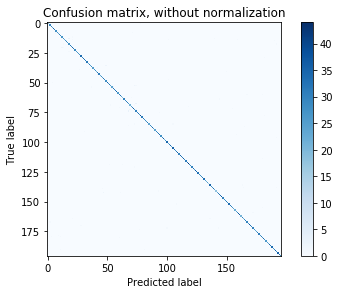

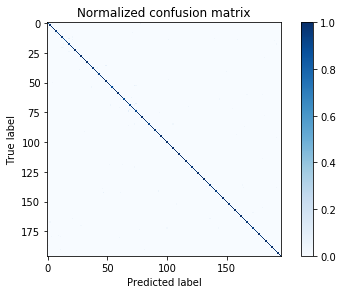

In [69]:
import matplotlib.pyplot as plt

from utils import load_model
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from keras.preprocessing import image

def decode_predictions(preds, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results


def predict(img_dir, model):
    img_files = []
    for root, dirs, files in os.walk(img_dir, topdown=False):
        for name in files:
            img_files.append(os.path.join(root, name))
    img_files = sorted(img_files)

    y_pred = []
    y_test = []

    for img_path in tqdm(img_files):
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        preds = model.predict(x[None, :, :, :])
        decoded = decode_predictions(preds, top=1)
        pred_label = decoded[0][0][0]
        y_pred.append(pred_label)
        tokens = img_path.split("\\")
        class_id = int(tokens[1])
        y_test.append(class_id)

    return y_pred, y_test


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def calc_acc(y_pred, y_test):
    num_corrects = 0
    for i in range(num_samples):
        pred = y_pred[i]
        test = y_test[i]
        if pred == test:
            num_corrects += 1
    return num_corrects / num_samples


if __name__ == '__main__':
    img_width, img_height = 224, 224
    num_channels = 3
    num_classes = 196
    class_names = range(1, (num_classes + 1))
    num_samples = 1629

    print("\nLoad the trained ResNet model....")
    model = load_model()

    y_pred, y_test = predict('data/valid', model)

    acc = calc_acc(y_pred, y_test)
    print("%s: %.2f%%" % ('acc', acc * 100))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

### Conjunto de datos de prueba

Se toma los datos de prueba y se verifica la probalilidad arojada por el algoritmo.
Para esto se procesan los 8041 y se saca el promedio de presición

In [85]:
import os
import time

import scipy.io
import cv2 as cv
import keras.backend as K
import numpy as np

from utils import load_model

if __name__ == '__main__':
    print("Cargando el modelo...")
    model = load_model()

    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)

    print("Predicting test data...")
    num_samples = 8041
    start = time.time()
    results = []
    avg_results = 0
    results.append(["Prediction","Probability"])
    for i in range(num_samples):
        filename = os.path.join('data/test', '%05d.jpg' % (i + 1))
        bgr_img = cv.imread(filename)
        rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
        rgb_img = np.expand_dims(rgb_img, 0)
        preds = model.predict(rgb_img)
        prob = np.max(preds)
        class_id = np.argmax(preds)
        text = ('Predict: {}, prob: {}'.format(class_names[class_id][0][0], prob))
        results.append([class_names[class_id][0][0], prob])
        avg_results = avg_results + prob

    end = time.time()
    seconds = end - start
    avg_results = avg_results / num_samples
    np.savetxt("test_results.csv", results, delimiter=",", fmt="%s")
    print('Test acc: {}'.format(avg_results))
    print('avg fps: {}'.format(str(num_samples / seconds)))

    out.close()
    K.clear_session()

Cargando el modelo...
Predicting test data...
Test acc: 0.9177656418154777
avg fps: 41.03184318951127


## Demo

Como parte de las pruebas realizadas, se decidio utilizar imagenes descargadas de internet para comprobar su correcto funcionamiento. Donde escargamos una imagen de cada modelo de vehiculo de marca Acura debido a su similitud. Ademas de eso se ingresan imagenes con diferentes vista del vehiculo y objetos a su alrededor.

Acura RL Sedan 2012
<img src="data\prediction\Acura_RL_Sedan_2012.jpg" width="320" height="320">


Acura TL Sedan 2012
<img src="data\prediction\Acura_TL_Sedan_2012.jpg" width="320" height="320">

Acura TL Type-S 2008
<img src="data\prediction\Acura_TL_Type-S_2008.jpg" width="320" height="320">

Acura TSX Sedan 2012
<img src="data\prediction\Acura_TSX_Sedan_2012.jpg" width="320" height="320">

Acura ZDX Hatchback 2012
<img src="data\prediction\Acura_ZDX_Hatchback_2012.jpg" width="320" height="320">

Acura Integra Type R 2001
<img src="data\prediction\Acura_Integra_Type_R_2001.jpg" width="320" height="320">

AM General Hummer SUV
<img src="data\prediction\AM_General_Hummer_SUV.jpg" width="320" height="320">

Por lo tanto si ejecutamos el codigo para realizar el demo, daria como resultdo un .csv donde mustra la probabilidad y la clase.

In [96]:
import os
import random

import cv2 as cv
import keras.backend as K
import numpy as np
import scipy.io

from utils import load_model

if __name__ == '__main__':
	img_width, img_height = 224, 224
	model = load_model()

	cars_meta = scipy.io.loadmat('devkit/cars_meta')
	class_names = cars_meta['class_names']  # shape=(1, 196)
	class_names = np.transpose(class_names)
	results = []
	results.append(["Prediction","Probability"])
	
	test_path = 'data/prediction/'
	i = -1
	for filename in os.listdir(test_path):
		print('Start processing')
		print('Image: {}'.format(filename))
		i = i + 1
		bgr_img = cv.imread(test_path + "/" + filename)
		bgr_img = cv.resize(bgr_img, (img_width, img_height), cv.INTER_CUBIC)
		rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
		rgb_img = np.expand_dims(rgb_img, 0)
		preds = model.predict(rgb_img)
		prob = np.max(preds)
		class_id = np.argmax(preds)
		text = ('Predict: {}, prob: {}'.format(class_names[class_id][0][0], prob))
		print(text)
		results.append([class_names[class_id][0][0], prob])
	np.savetxt("results.csv", results, delimiter=",", fmt="%s")
	K.clear_session()  

Start processing
Image: Acura_Integra_Type_R_2001.jpg
Predict: Acura Integra Type R 2001, prob: 0.9951942563056946
Start processing
Image: Acura_RL_Sedan_2012.jpg
Predict: Acura RL Sedan 2012, prob: 0.9967875480651855
Start processing
Image: Acura_TL_Sedan_2012.jpg
Predict: Acura TL Sedan 2012, prob: 0.999991774559021
Start processing
Image: Acura_TL_Type-S_2008.jpg
Predict: Acura TL Type-S 2008, prob: 0.9997209906578064
Start processing
Image: Acura_TSX_Sedan_2012.jpg
Predict: Acura TSX Sedan 2012, prob: 0.9982661604881287
Start processing
Image: Acura_ZDX_Hatchback_2012.jpg
Predict: Acura ZDX Hatchback 2012, prob: 0.9999839067459106
Start processing
Image: AM_General_Hummer_SUV.jpg
Predict: AM General Hummer SUV 2000, prob: 0.9348713159561157


# Bibliografía
Foam, Liu.  "Car-Recognition."  GitHub.  https://github.com/foamliu/Car-Recognition

"Residual neural network". Wikipedia.  14 de agosto de 2019. https://en.wikipedia.org/wiki/Residual_neural_network

He, K., Zhang, X., Ren, S. y Sun, J.  "Review of Identity Mappings in Deep Residual Networks".  Publicado por Olafenwa, J. en Medium. 25 e abril de 2018.  https://medium.com/deepreview/review-of-identity-mappings-in-deep-residual-networks-ad6533452f33